In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import chromadb
import pandas as pd
from chromadb.config import Settings
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

### Load Synthetic Dataset

In [3]:
csv_file_path = 'data/synthetic_clusters_colored.csv'
data = pd.read_csv(csv_file_path)

In [4]:
query_color = "purple"
query_point = data[data['cluster'] == query_color][['x', 'y']].iloc[0]

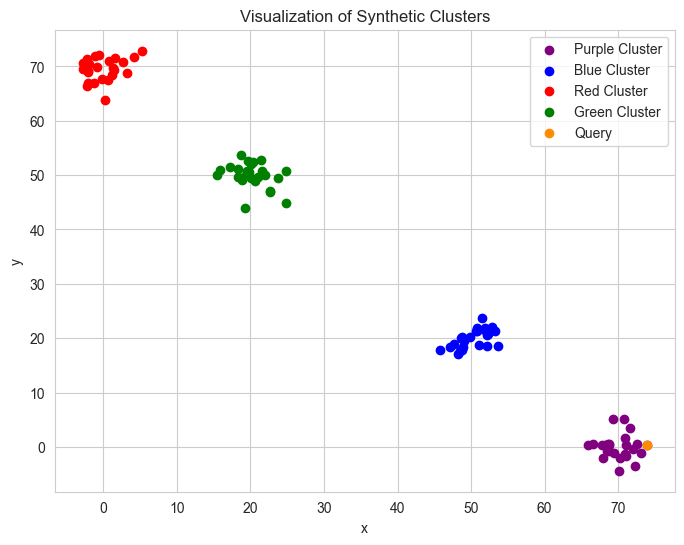

In [5]:
plt.figure(figsize=(8, 6))
for color in data['cluster'].unique().tolist():
    # Select data points belonging to each cluster/color
    cluster_data = data[data['cluster'] == color]
    plt.scatter(cluster_data['x'], cluster_data['y'], color=color, label=f'{color.capitalize()} Cluster')

# Highlight the query point
plt.scatter(query_point['x'], query_point['y'], color='darkorange', edgecolor='darkorange', label='Query', zorder=5)

plt.title('Visualization of Synthetic Clusters')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### Setup Database

In [6]:
client = chromadb.Client()

collections = client.list_collections()
if collections:
    client.delete_collection(collections[0].name)

In [7]:
n_categories = [2]

index_configuraiton = {
    "lmi:epochs": "[200]",
    "lmi:model_types": "['MLP']",
    "lmi:lrs": "[0.01]",
    "lmi:n_categories": f"{str(n_categories)}",
    "lmi:kmeans": "{'verbose': False, 'seed': 2023, 'nredo': 10}",
}

collection_name = "synthetic_collection"
collection = client.create_collection(
    name=collection_name,
    metadata=index_configuraiton
)

In [8]:
# Use batch upload just to test it out
batch_size = 25
for i in tqdm(range(0, len(data), batch_size), desc="Adding documents"):
    collection.add(
        embeddings=data[['x', 'y']].iloc[i: i + batch_size].values.tolist(),
        metadatas=[{"cluster": cluster} for cluster in data['cluster'].iloc[i: i + batch_size]],
        ids=data['id'].iloc[i: i + batch_size].values.tolist(),
    )

bucket_assignment = collection.build_index()

# Map the ids in data to buckets using bucket_labels_new_format (assuming this exists outside this function)
data['bucket'] = data['id'].map(lambda x: list(bucket_assignment.get(x, [])))
data['bucket_str'] = data['bucket'].apply(lambda x: str(x))

Adding documents:   0%|          | 0/4 [00:00<?, ?it/s]


            LMI Build Config:
            {
                clustering_algorithms: [<function cluster at 0x0000022B26912DC0>],
                epochs: [200],
                model_types: ['MLP'],
                learning_rate: [0.01],
                n_categories: [2],
            }
             
FAISS Kmeans parameters {'verbose': False, 'seed': 2023, 'nredo': 10}
LMI built with n_buckets_in_index: 2
Time taken to build: 0.9196927547454834; Time taken to cluster: 0.01922893524169922


### Visualize buckets

In [9]:
def plot_bucket_items(data, use_colors):
    """
    Plot the number of items in each bucket, with optional color coding by cluster.

    Parameters:
    data (DataFrame): The data frame containing the 'id', 'bucket', and 'cluster' columns.
    use_colors (bool): If True, use different colors for each cluster in the visualization.
    """
    if use_colors:
        # Count the number of points from each cluster in each mapped bucket
        bucket_cluster_counts = data.groupby(['bucket_str', 'cluster']).size().unstack(fill_value=0)
        plot_data = bucket_cluster_counts.reset_index().melt(id_vars='bucket_str', var_name='cluster', value_name='count')
        palette = {cluster: cluster for cluster in data['cluster'].unique()}
        
        # Create the bar plot with colors
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(data=plot_data, x='bucket_str', y='count', hue='cluster', palette=palette)
    else:
        # Count the total number of items in each bucket
        bucket_counts = data.groupby('bucket_str').size()
        plot_data = bucket_counts.reset_index(name='count')

        # Create the bar plot without colors
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(data=plot_data, x='bucket_str', y='count')
    
    plt.title('Number of Items in Each Bucket')
    plt.xlabel('Bucket')
    plt.ylabel('Count')

    # Annotate each bar with the count of elements
    for p in ax.patches:
        bar_height = int(p.get_height())
        if bar_height > 0:  # Only annotate bars with a height greater than zero
            ax.annotate(f'{bar_height}', (p.get_x() + p.get_width() / 2., bar_height),
                        ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                        textcoords='offset points')

    plt.show()

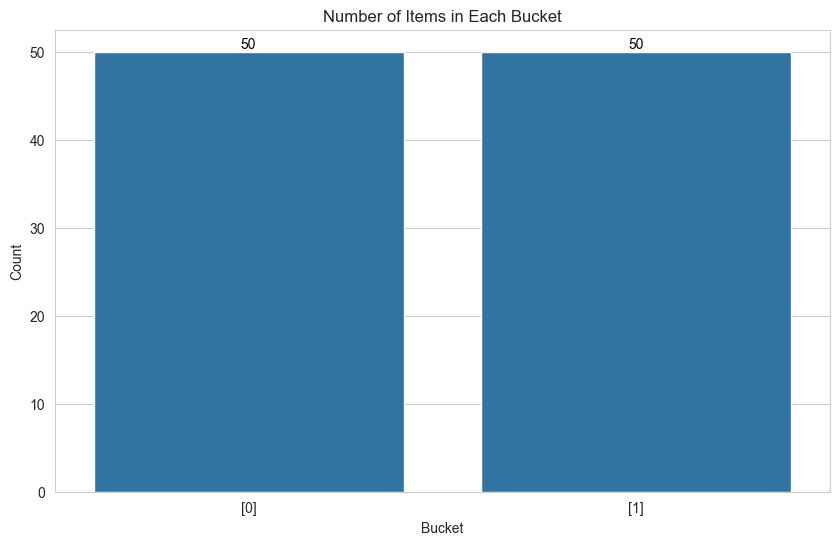

In [10]:
plot_bucket_items(data, False)

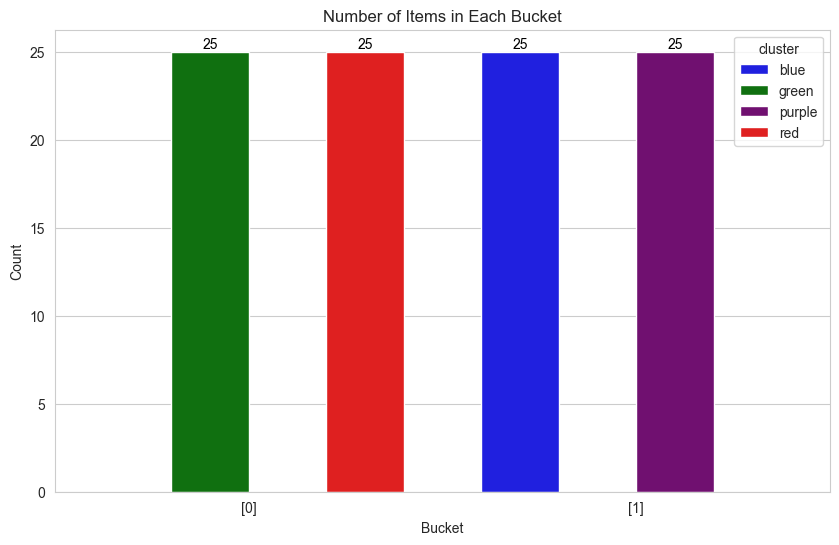

In [11]:
plot_bucket_items(data, True)

### Perform Qeries and visualize their bucket order 

In [12]:
def visualize_bucket_order(data, bucket_order):
    order_labels = [str(list(bucket)) for bucket in bucket_order]  # Convert to string with brackets

    bucket_cluster_counts = data.groupby(['bucket_str', 'cluster']).size().unstack(fill_value=0)
    # Extract the counts for the specified color
    cluster_specific_counts = bucket_cluster_counts[filter_color]
    
    # Reindex the bucket counts according to the specified order
    ordered_counts = cluster_specific_counts.reindex(order_labels, fill_value=0).reset_index()
    ordered_counts.columns = ['bucket', 'count']
    
    # Create the bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=ordered_counts, x='bucket', y='count', color=filter_color)
    plt.title(f'Number of Items from {filter_color} Cluster in Ordered Buckets')
    plt.xlabel('Bucket')
    plt.ylabel('Count')
    plt.show()

In [13]:
# Output from ChromaDB
expected_output = [['id70', 'id74', 'id10', 'id86', 'id29', 'id76', 'id92', 'id3', 'id23', 'id47']]

In [14]:
%%time
filter_color = "red"
results = collection.query(
    query_embeddings=list(query_point),
    include=["metadatas", 'embeddings', 'distances'],
    where={"cluster": filter_color},
    n_results=10,
    n_buckets=2,
    bruteforce_threshold=0.0,
    constraint_weight=0.0,
)

[2024-01-04 14:33:17,699][INFO ][chromadb.li_index.se] Precomputed bucket order time: 0.0014190673828125


filter_restrictiveness 0.25
constraint_weight 0.0
Number of buckets searched:  2
CPU times: total: 0 ns
Wall time: 13 ms


In [15]:
print(results['ids'])
print(results['distances'])
print(results['metadatas'])
print(results['bucket_order'])
print(results['bruteforce_used'])
print(results['constraint_weight'])
assert results['ids'] == expected_output

[['id70', 'id74', 'id10', 'id86', 'id29', 'id76', 'id92', 'id3', 'id23', 'id47']]
[[0.9229794144630432, 0.9372906684875488, 0.9492100477218628, 0.9582650065422058, 0.9740304350852966, 0.9750983119010925, 0.9771788716316223, 0.9781938195228577, 0.985159695148468, 0.98552405834198]]
[[{'cluster': 'red'}, {'cluster': 'red'}, {'cluster': 'red'}, {'cluster': 'red'}, {'cluster': 'red'}, {'cluster': 'red'}, {'cluster': 'red'}, {'cluster': 'red'}, {'cluster': 'red'}, {'cluster': 'red'}]]
[[[1]
  [0]]]
False
0.0


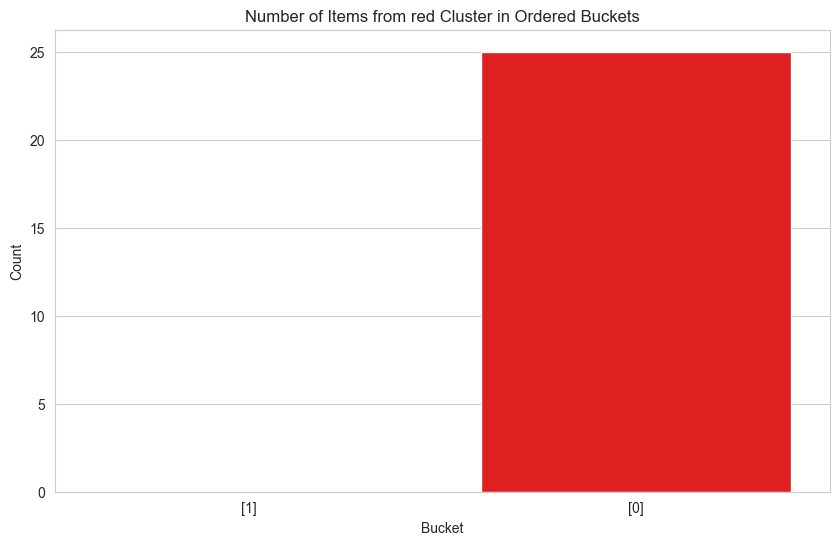

In [16]:
visualize_bucket_order(data, results['bucket_order'][0])

In [17]:
expected_output = [['id70', 'id74', 'id10', 'id86', 'id29', 'id76', 'id92', 'id3', 'id23', 'id47']]

In [18]:
%%time
results = collection.query(
    query_embeddings=list(query_point),
    include=["metadatas", 'embeddings', 'distances'],
    where={"cluster": filter_color},
    n_results=10,
    n_buckets=1,
    bruteforce_threshold=0.0, 
    constraint_weight=0.5, 
)

[2024-01-04 14:33:18,310][INFO ][chromadb.li_index.se] Precomputed bucket order time: 0.0


filter_restrictiveness 0.25
constraint_weight 0.5
Number of buckets searched:  1
CPU times: total: 0 ns
Wall time: 7.24 ms


In [19]:
print(results['ids'])
print(results['distances'])
print(results['metadatas'])
print(results['bucket_order'])
print(results['bruteforce_used'])
print(results['constraint_weight'])
assert results['ids'] == expected_output

[['id70', 'id74', 'id10', 'id86', 'id29', 'id76', 'id92', 'id3', 'id23', 'id47']]
[[0.9229794144630432, 0.9372906684875488, 0.9492100477218628, 0.9582650065422058, 0.9740304350852966, 0.9750983119010925, 0.9771788716316223, 0.9781938195228577, 0.985159695148468, 0.98552405834198]]
[[{'cluster': 'red'}, {'cluster': 'red'}, {'cluster': 'red'}, {'cluster': 'red'}, {'cluster': 'red'}, {'cluster': 'red'}, {'cluster': 'red'}, {'cluster': 'red'}, {'cluster': 'red'}, {'cluster': 'red'}]]
[[[0]]]
False
0.5


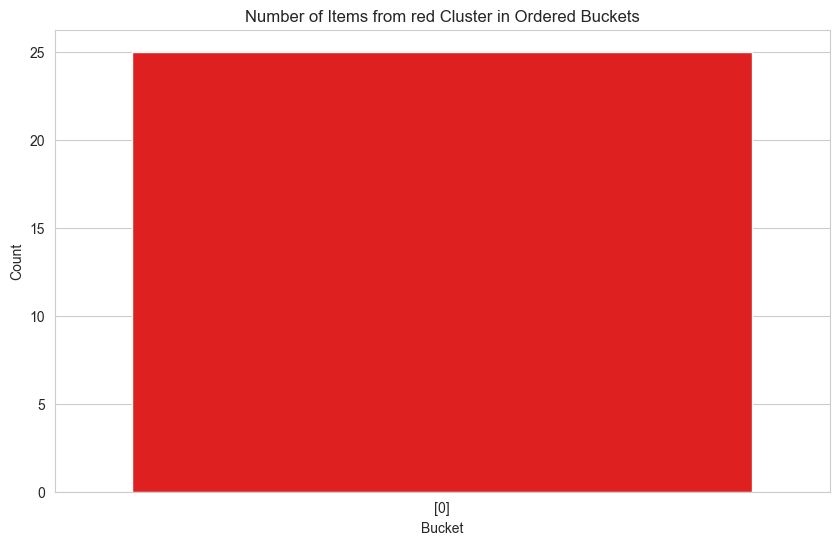

In [20]:
visualize_bucket_order(data, results['bucket_order'][0])